<a href="https://colab.research.google.com/github/Radhikaag2006/Stock-Market-Prediction-Model/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter stock ticker (e.g. AAPL, GOOGL, MSFT): AAPL
Enter number of days to predict: 12

Data loaded for AAPL
                              close    high      low    open    volume  \
date                                                                     
2014-01-02 00:00:00+00:00  553.1300  557.03  552.021  555.68   8381600   
2014-01-03 00:00:00+00:00  540.9800  553.70  540.430  552.86  14016700   
2014-01-06 00:00:00+00:00  543.9300  546.80  533.600  537.45  14736100   
2014-01-07 00:00:00+00:00  540.0375  545.96  537.925  544.32  11328900   
2014-01-08 00:00:00+00:00  543.4600  545.56  538.690  538.81   9233200   

                            adjClose    adjHigh     adjLow    adjOpen  \
date                                                                    
2014-01-02 00:00:00+00:00  17.157690  17.278665  17.123290  17.236789   
2014-01-03 00:00:00+00:00  16.780806  17.175371  16.763745  17.149315   
2014-01-06 00:00:00+00:00  16.872313  16.961338  16.551884  16.671308   
2014-01-

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - loss: 0.0171 - val_loss: 4.3319e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0046 - val_loss: 6.4987e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0036 - val_loss: 3.7835e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.0028 - val_loss: 1.4895e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 0.0029 - val_loss: 1.7947e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 0.0022 - val_loss: 4.4593e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 0.0024 - val_loss: 2.7463e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.0025 - val_loss: 5.6754e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - loss: 0.0020 - val_loss: 6.0802e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 12/50
27/27 ━━━━━━

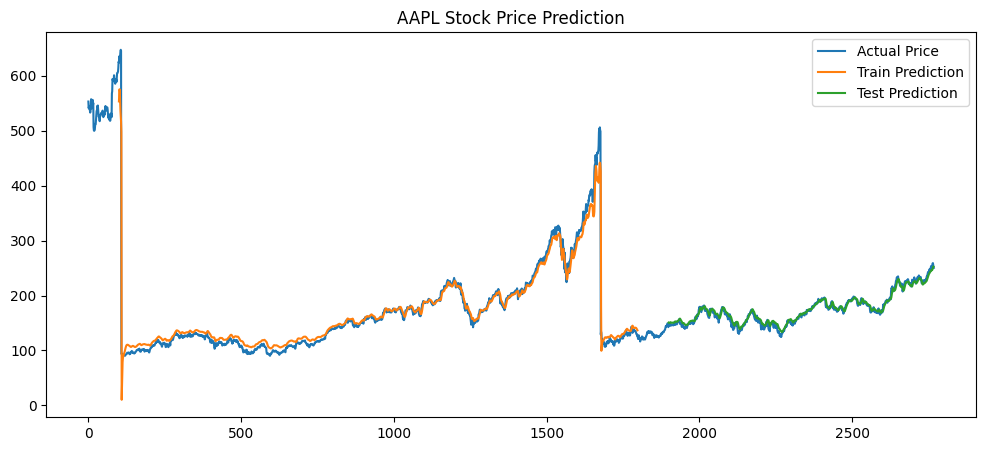

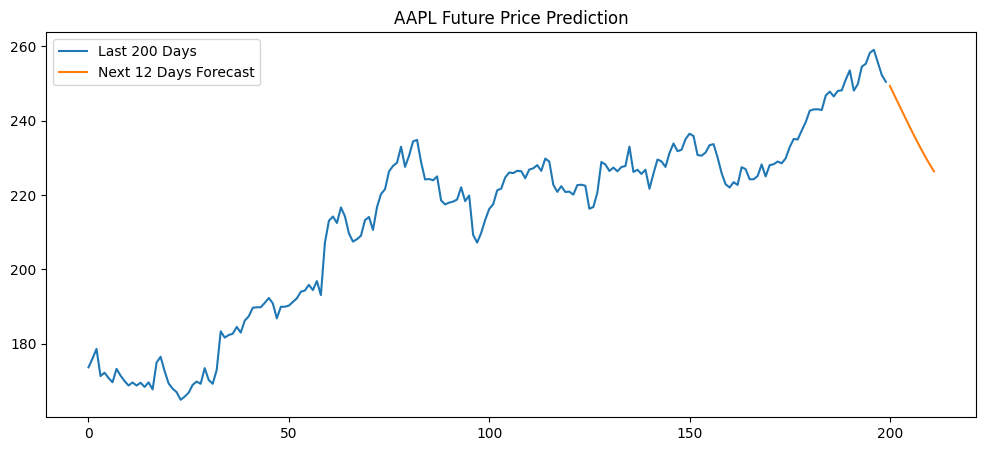

In [2]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# ===============================
# 2. USER INPUTS
# ===============================
API_KEY = "a5f9e67af96bb64f2d54475629d0619f48cc0ee9"

TICKER = input("Enter stock ticker (e.g. AAPL, GOOGL, MSFT): ").upper()
FUTURE_DAYS = int(input("Enter number of days to predict: "))

START_DATE = "2014-01-01"
END_DATE = "2025-01-01"
TIME_STEP = 100


# ===============================
# 3. FETCH DATA FROM TIINGO
# ===============================
url = f"https://api.tiingo.com/tiingo/daily/{TICKER}/prices"
params = {
    "startDate": START_DATE,
    "endDate": END_DATE,
    "token": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if isinstance(data, dict) and data.get("detail"):
    raise ValueError("Invalid ticker symbol or API error")

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['Close'] = df['close']

print(f"\nData loaded for {TICKER}")
print(df.head())


# ===============================
# 4. PREPROCESS DATA
# ===============================
close_prices = df[['Close']]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

training_size = int(len(scaled_data) * 0.65)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]


# ===============================
# 5. CREATE DATASET FUNCTION
# ===============================
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

X_train = X_train.reshape(X_train.shape[0], TIME_STEP, 1)
X_test = X_test.reshape(X_test.shape[0], TIME_STEP, 1)


# ===============================
# 6. BUILD LSTM MODEL
# ===============================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEP,1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')


# ===============================
# 7. TRAIN MODEL
# ===============================
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)


# ===============================
# 8. EVALUATION
# ===============================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

print("\nTrain RMSE:", math.sqrt(mean_squared_error(y_train_inv, train_predict)))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test_inv, test_predict)))


# ===============================
# 9. PLOT TRAIN & TEST RESULTS
# ===============================
look_back = TIME_STEP
plot_data = scaler.inverse_transform(scaled_data)

train_plot = np.empty_like(plot_data)
train_plot[:] = np.nan
train_plot[look_back:len(train_predict)+look_back] = train_predict

test_plot = np.empty_like(plot_data)
test_plot[:] = np.nan
test_plot[len(train_predict)+(look_back*2)+1:len(plot_data)-1] = test_predict

plt.figure(figsize=(12,5))
plt.plot(plot_data, label="Actual Price")
plt.plot(train_plot, label="Train Prediction")
plt.plot(test_plot, label="Test Prediction")
plt.title(f"{TICKER} Stock Price Prediction")
plt.legend()
plt.show()


# ===============================
# 10. FUTURE PREDICTION (X DAYS)
# ===============================
last_data = test_data[-TIME_STEP:]
temp_input = list(last_data.reshape(-1))

future_predictions = []

for i in range(FUTURE_DAYS):
    x_input = np.array(temp_input[-TIME_STEP:]).reshape(1, TIME_STEP, 1)
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    future_predictions.append(yhat[0])

future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1,1)
)


# ===============================
# 11. FUTURE FORECAST PLOT
# ===============================
plt.figure(figsize=(12,5))
plt.plot(plot_data[-200:], label="Last 200 Days")
plt.plot(
    range(200, 200 + FUTURE_DAYS),
    future_predictions,
    label=f"Next {FUTURE_DAYS} Days Forecast"
)
plt.title(f"{TICKER} Future Price Prediction")
plt.legend()
plt.show()
